### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [3]:
df=pd.read_excel("BG_sample18.xlsx")

In [4]:
df.shape

(1474, 14)

In [5]:
df.head(13)

색인 타임스탬프(YYYY-MM-DDThh:mm:ss) 이벤트 유형 이벤트 하위 유형                환자 정보  \
0    1                        NaN     이름       NaN                  sch   
1    2                        NaN      성       NaN                    3   
2    3                        NaN   생년월일       NaN  1983-01-24 00:00:00   
3    4                        NaN     장치       NaN                  NaN   
4    5                        NaN     경고        하락                  NaN   
5    6                        NaN     경고        높음                  NaN   
6    7                        NaN     경고        낮음                  NaN   
7    8                        NaN     경고     신호 손실                  NaN   
8    9                        NaN     경고        상승                  NaN   
9   10                        NaN     경고   긴급하게 낮음                  NaN   
10  11        2020-03-13T11:05:03     교정       NaN                  NaN   
11  12        2020-03-13T11:14:06     교정       NaN                  NaN   
12  13        2020-03-13T11:15:55    EGV       NaN                  NaN   

                   장치 정보 소스 장치 ID 포도당 값 (mg/dL)  인슐린 값(u)  탄수화물 값 (그램)  \
0                    NaN      NaN           NaN       NaN          NaN   
1                    NaN      NaN           NaN       NaN          NaN   
2                    NaN      NaN           NaN       NaN          NaN   
3   Dexcom G5 Mobile App  Android           NaN       NaN          NaN   
4                    NaN  Android           NaN       NaN          NaN   
5                    NaN  Android           250       NaN          NaN   
6                    NaN  Android            70       NaN          NaN   
7                    NaN  Android           NaN       NaN          NaN   
8                    NaN  Android           NaN       NaN          NaN   
9                    NaN  Android            55       NaN          NaN   
10                   NaN  Android           216       NaN          NaN   
11                   NaN  Android           244       NaN          NaN   
12                   NaN  Android           227       NaN          NaN   

   기간(hh:mm:ss)  포도당 변화율 (mg/dL/min)  트랜스미터 시간 (배장 정수) 트랜스미터 ID  
0           NaN                  NaN               NaN      NaN  
1           NaN                  NaN               NaN      NaN  
2           NaN                  NaN               NaN      NaN  
3           NaN                  NaN               NaN      NaN  
4           NaN                  3.0               NaN      NaN  
5           NaN                  NaN               NaN      NaN  
6           NaN                  NaN               NaN      NaN  
7      00:30:00                  NaN               NaN      NaN  
8           NaN                  3.0               NaN      NaN  
9           NaN                  NaN               NaN      NaN  
10          NaN                  NaN               NaN   42E570  
11          NaN                  NaN               NaN   42E570  
12          NaN                  NaN         6134328.0   42E570

In [6]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '인슐린 값(u)', '탄수화물 값 (그램)', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [7]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event'},axis='columns')

In [8]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
경고         6
교정         4
이름         1
생년월일       1
장치         1
성          1
Name: Event, dtype: int64

In [9]:
df['Glucose'].value_counts()

높음     169
199     27
187     20
185     19
203     18
      ... 
285      1
284      1
279      1
272      1
55       1
Name: Glucose, Length: 242, dtype: int64

In [10]:
df.tail()

Timestamp Event Glucose
1469  2020-03-18T09:20:43   EGV      높음
1470  2020-03-18T09:25:44   EGV      높음
1471  2020-03-18T09:30:43   EGV      높음
1472  2020-03-18T09:35:44   EGV      높음
1473  2020-03-18T09:40:44   EGV      높음

In [11]:
df.head(15)

Timestamp Event Glucose
0                   NaN    이름     NaN
1                   NaN     성     NaN
2                   NaN  생년월일     NaN
3                   NaN    장치     NaN
4                   NaN    경고     NaN
5                   NaN    경고     250
6                   NaN    경고      70
7                   NaN    경고     NaN
8                   NaN    경고     NaN
9                   NaN    경고      55
10  2020-03-13T11:05:03    교정     216
11  2020-03-13T11:14:06    교정     244
12  2020-03-13T11:15:55   EGV     227
13  2020-03-13T11:20:50   EGV     227
14  2020-03-13T11:25:49   EGV     224

In [12]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [13]:
df.head(15)

Timestamp Event Glucose
10  2020-03-13T11:05:03    교정     216
11  2020-03-13T11:14:06    교정     244
12  2020-03-13T11:15:55   EGV     227
13  2020-03-13T11:20:50   EGV     227
14  2020-03-13T11:25:49   EGV     224
15  2020-03-13T11:30:49   EGV     223
16  2020-03-13T11:35:49   EGV     222
17  2020-03-13T11:40:50   EGV     222
18  2020-03-13T11:45:51   EGV     218
19  2020-03-13T11:50:49   EGV     218
20  2020-03-13T11:55:50   EGV     218
21  2020-03-13T12:00:51   EGV     223
22  2020-03-13T12:05:50   EGV     217
23  2020-03-13T12:10:50   EGV     201
24  2020-03-13T12:11:14   인슐린     NaN

In [14]:
df.shape

(1464, 3)

In [15]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [16]:
df.head(15)

Timestamp Event Glucose
0   2020-03-13T11:05:03    교정     216
1   2020-03-13T11:14:06    교정     244
2   2020-03-13T11:15:55   EGV     227
3   2020-03-13T11:20:50   EGV     227
4   2020-03-13T11:25:49   EGV     224
5   2020-03-13T11:30:49   EGV     223
6   2020-03-13T11:35:49   EGV     222
7   2020-03-13T11:40:50   EGV     222
8   2020-03-13T11:45:51   EGV     218
9   2020-03-13T11:50:49   EGV     218
10  2020-03-13T11:55:50   EGV     218
11  2020-03-13T12:00:51   EGV     223
12  2020-03-13T12:05:50   EGV     217
13  2020-03-13T12:10:50   EGV     201
14  2020-03-13T12:11:14   인슐린     NaN

In [17]:
df.shape

(1464, 3)

In [18]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]

In [19]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [20]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [21]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [22]:
glucose_count_high(df,'Glucose')

높음 :  169


In [23]:
print('높음 개수 :',len(high_list))

높음 개수 : 169


In [24]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [25]:
print('교정 개수 :',len(calib_list))

교정 개수 : 0


In [26]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [27]:
low_list

[]

In [28]:
calibration_count_low(df,'Event')

교정 :  4


In [29]:
calib_list

[0, 1, 139, 414]

In [30]:
df.isnull().sum()

Timestamp     0
Event         0
Glucose      38
dtype: int64

In [31]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
교정         4
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [32]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400

In [33]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [34]:
fix_glucose(df,'Glucose')

In [35]:
fix_glucose_low(df,'Glucose')

In [36]:
df['Glucose'].value_counts()

400    169
199     27
187     20
185     19
197     18
      ... 
171      1
169      1
389      1
366      1
145      1
Name: Glucose, Length: 240, dtype: int64

In [37]:
df.isnull().sum()

Timestamp     0
Event         0
Glucose      38
dtype: int64

In [38]:
df['Event'].unique()

array(['교정', 'EGV', '인슐린', '탄수화물'], dtype=object)

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


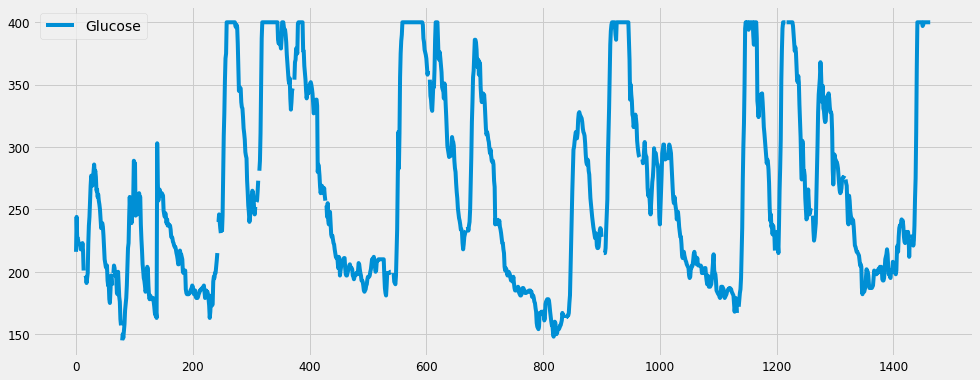

In [39]:
df.plot(figsize=(15,6))
plt.show()

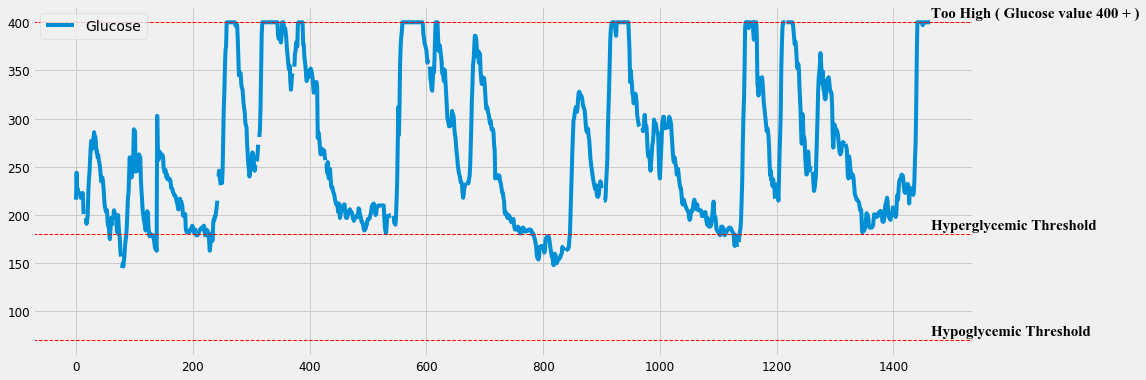

In [40]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [41]:
#df.drop(0,inplace=True)

In [42]:
# drop한 인스턴스가 있어서 인덱스 리셋
#df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
#df=df.reset_index(drop=True)
#df.head(21)

In [43]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
insul=list()
import math
def interpolate_glucose(df,col):
    #insul=list()
    
    for i, row in df.iterrows():
        val=row[col]
        if math.isnan(val):
            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
                df.loc[i,col]= df['Glucose'][i-1] - c
                insul.append(i)
                print(insul)
                
            if df['Glucose'][i-2] < df['Glucose'][i-1]:
                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
                df.loc[i,col]= df['Glucose'][i-1] - c
                insul.append(i)
                print(insul)
        
           

In [44]:
# 인슐린 탄수화물 인덱스 문제 해결 파트 
#insul=list()
#meal=list()
#import math
#def interpolate_glucose(df,col):
    #insul=list()
    
#    for i, row in df.iterrows():
#        val=row[col]
        #df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
        #df=df.reset_index(drop=True)
#        if math.isnan(val):
 #           if df['Event'][i]=='인슐린':
  #              if df['Glucose'][i-1] is None:
   #                 insul.append(i-2)
                    
                    
    #            else:
     #               insul.append(i-1)
                    
      #      if df['Event'][i]=='탄수화물':
       #         if df['Glucose'][i-1] is None:
        #            meal.append(i-2)
                    
         #       else:
          #          meal.append(i-1)
                    

In [45]:
interpolate_glucose(df,'Glucose')

[14]
[14, 15]
[14, 15, 63]
[14, 15, 63, 78]
[14, 15, 63, 78, 243]
[14, 15, 63, 78, 243, 249]
[14, 15, 63, 78, 243, 249, 308]
[14, 15, 63, 78, 243, 249, 308, 313]
[14, 15, 63, 78, 243, 249, 308, 313, 372]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605, 669]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605, 669, 670]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605, 669, 670, 720]
[14,

In [46]:
#meal

In [47]:
insul

[14,
 15,
 63,
 78,
 243,
 249,
 308,
 313,
 372,
 373,
 428,
 540,
 541,
 542,
 543,
 604,
 605,
 669,
 670,
 720,
 837,
 838,
 901,
 903,
 966,
 967,
 968,
 969,
 1133,
 1134,
 1198,
 1199,
 1216,
 1260,
 1261,
 1317,
 1429,
 1431]

In [48]:
df.head(21)

Timestamp Event Glucose
0   2020-03-13T11:05:03    교정     216
1   2020-03-13T11:14:06    교정     244
2   2020-03-13T11:15:55   EGV     227
3   2020-03-13T11:20:50   EGV     227
4   2020-03-13T11:25:49   EGV     224
5   2020-03-13T11:30:49   EGV     223
6   2020-03-13T11:35:49   EGV     222
7   2020-03-13T11:40:50   EGV     222
8   2020-03-13T11:45:51   EGV     218
9   2020-03-13T11:50:49   EGV     218
10  2020-03-13T11:55:50   EGV     218
11  2020-03-13T12:00:51   EGV     223
12  2020-03-13T12:05:50   EGV     217
13  2020-03-13T12:10:50   EGV     201
14  2020-03-13T12:11:14   인슐린     193
15  2020-03-13T12:11:34  탄수화물     189
16  2020-03-13T12:15:50   EGV     197
17  2020-03-13T12:20:50   EGV     196
18  2020-03-13T12:25:50   EGV     191
19  2020-03-13T12:30:49   EGV     195
20  2020-03-13T12:35:50   EGV     199

In [49]:
glucose_value=list()
for i in range(0,len(insul)):
    glucose_value.append(df['Glucose'][insul[i]])

In [50]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

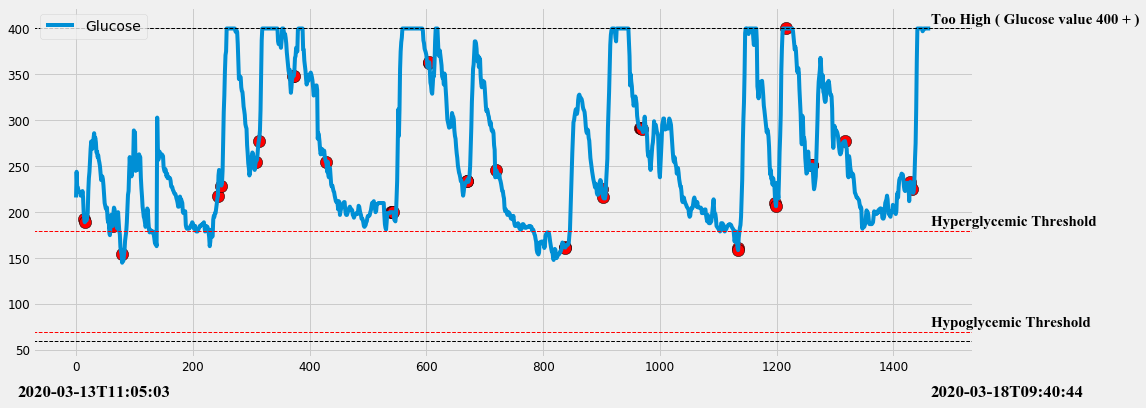

In [51]:

df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='black',linestyle='--',linewidth=1)
plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.scatter(insul,glucose_value,c='red',edgecolor='black',s=150)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',
#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

In [52]:
import numpy as np
import tensorflow as tf
import random as rn

In [53]:
# 재현 가능한 결과를 만들기 위해 시드값 설정 
import os 
import random
seed_num = 42
os.environ['PYTHONHASHSEED']=str(seed_num)

random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

In [54]:
from tensorflow.compat.v1.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [55]:
#from keras import backend as K
#session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#tf.compat.v1.keras.backend.set_session(sess)


In [56]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

## 15분

In [57]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [58]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')

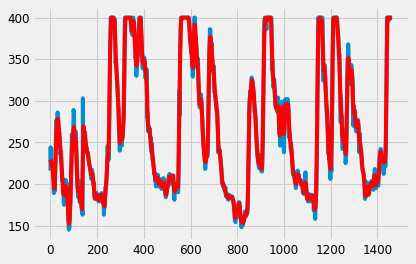

In [59]:
# SG필터 테스트 
import scipy.signal 

yhat = scipy.signal.savgol_filter(raw_seq,7,1)
plt.plot(raw_seq)
plt.plot(yhat,color='red')
plt.show()

In [60]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [61]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=2 # 이거 -1이면 naive method 
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [62]:
x_train_uni.shape

(1018, 6, 1)

In [63]:
y_train_uni.shape

(1018,)

In [64]:
x_train_uni[2]

array([[227.10714286],
       [226.14285714],
       [227.        ],
       [223.28571429],
       [222.        ],
       [220.71428571]])

In [65]:
y_train_uni[2]

216.71428571428575

In [66]:
df['Glucose'].head(10)

0    216
1    244
2    227
3    227
4    224
5    223
6    222
7    222
8    218
9    218
Name: Glucose, dtype: object

### RNN - 15분

In [67]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [68]:
from keras.layers import SimpleRNN

In [69]:
n_steps = 3
#delay=3
n_features=1

In [70]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)


In [71]:
K.set_session(sess)

In [72]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=(n_steps,n_features),return_sequences=False))
model.add(Dense(1))

In [73]:
model.compile(optimizer='adam',loss='mse')

In [74]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [75]:
K.clear_session()

In [76]:
predict_result = model.predict(x_val_uni,verbose=0)

In [77]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [78]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_15 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  10.197750020810199


#### Validation

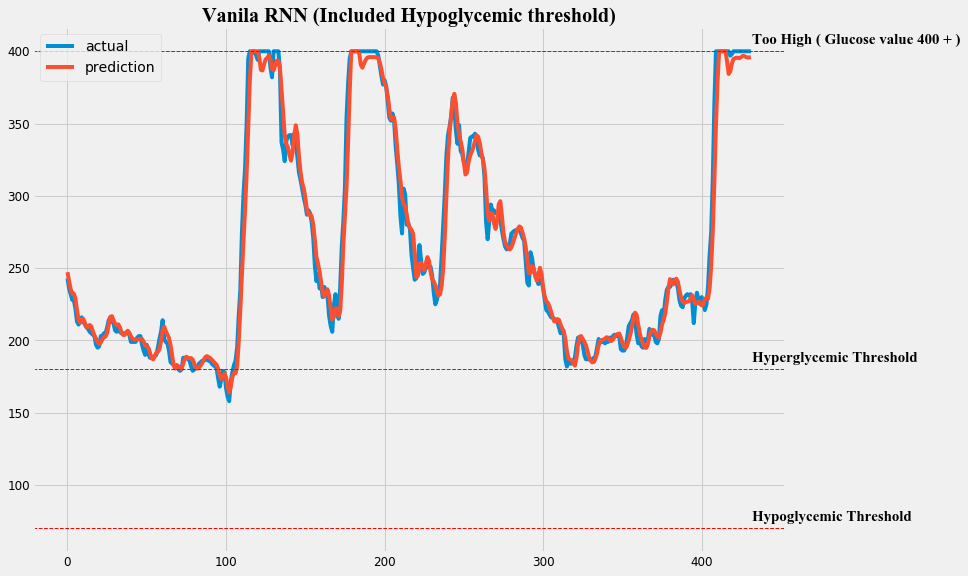

In [79]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [80]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


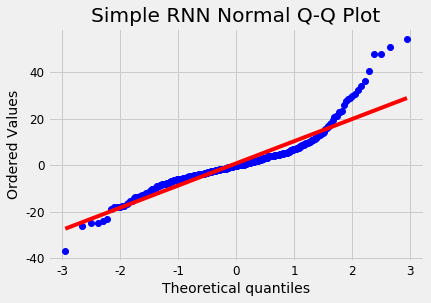

In [81]:
residuals = [y_val_uni_origin[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni_origin - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

#### 잔차

Text(0.5, 1.0, 'Simple RNN Normal Q-Q Plot')

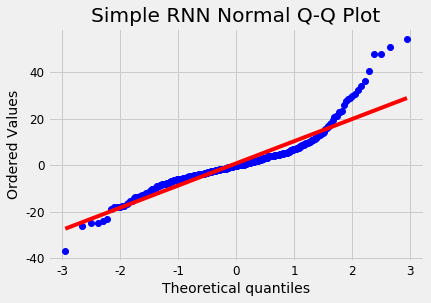

In [82]:
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Normal Q-Q Plot")

In [83]:
residuals=DataFrame(residuals)

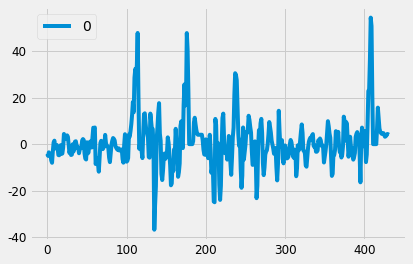

In [84]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000206D6F4DFC8>]],
      dtype=object)

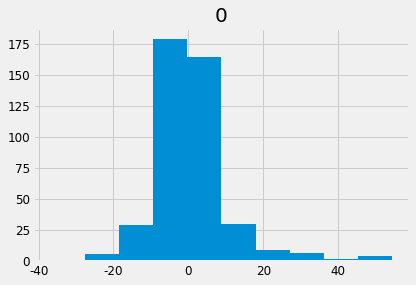

In [85]:

residuals.hist()

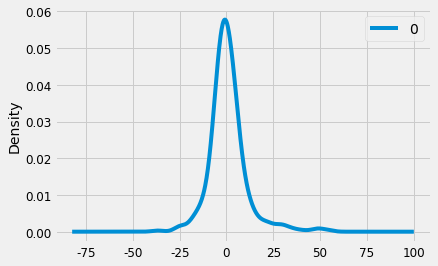

In [86]:
residuals.plot(kind='kde')

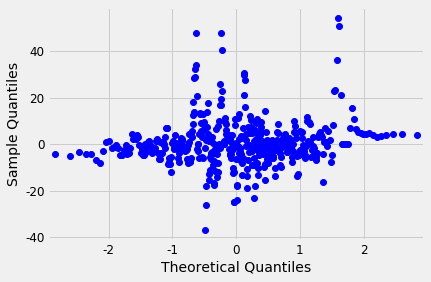

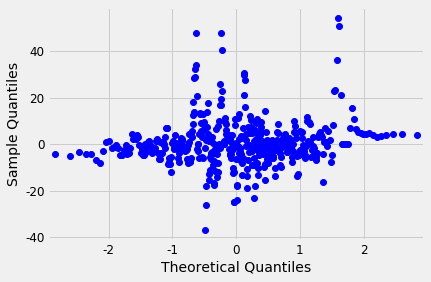

In [87]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

In [88]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_15=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  8.99884722713793


#### Train

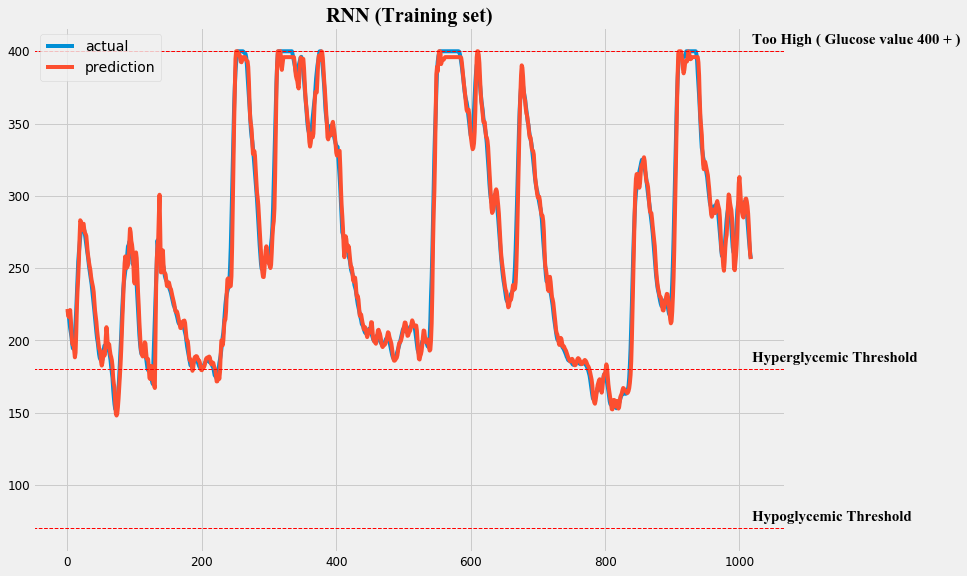

In [89]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

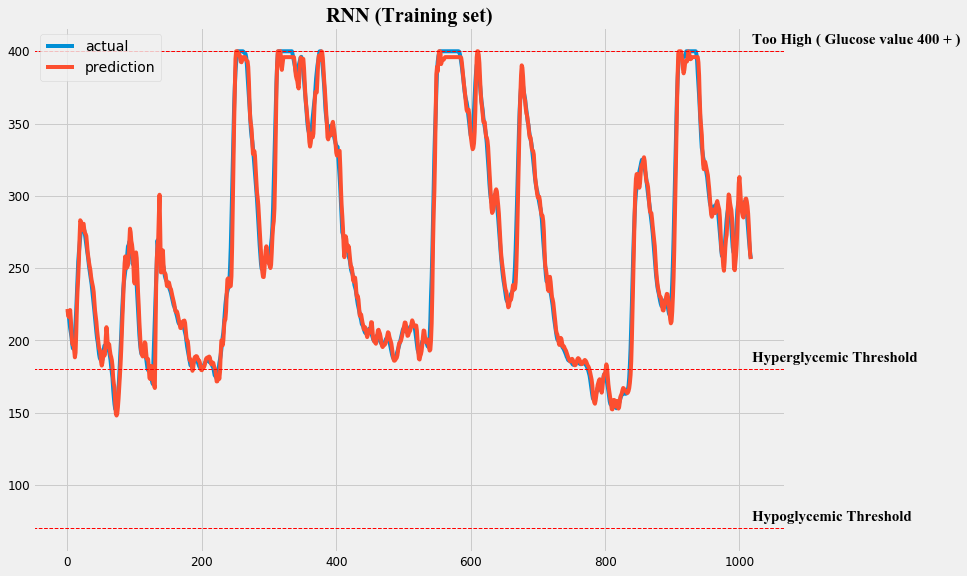

In [90]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

### LSTM - 15분

In [91]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [92]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))


In [93]:
model.compile(optimizer='adam',loss='mse')

In [94]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [95]:
K.clear_session()

In [96]:
predict_result = model.predict(x_val_uni,verbose=0)

In [97]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [98]:
#predict_result

In [99]:
print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_15=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  12.218394394129966


In [100]:
TRAIN_SPLIT

1024

#### 잔차

Text(0.5, 1.0, 'LSTM Normal Q-Q Plot')

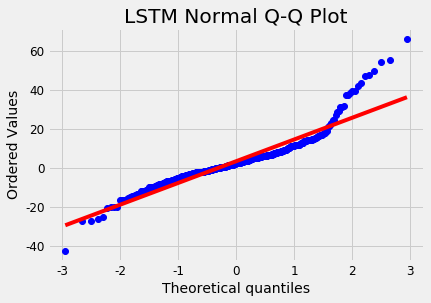

In [101]:
residuals = [y_val_uni_origin[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni_origin - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Normal Q-Q Plot")

#### Validation

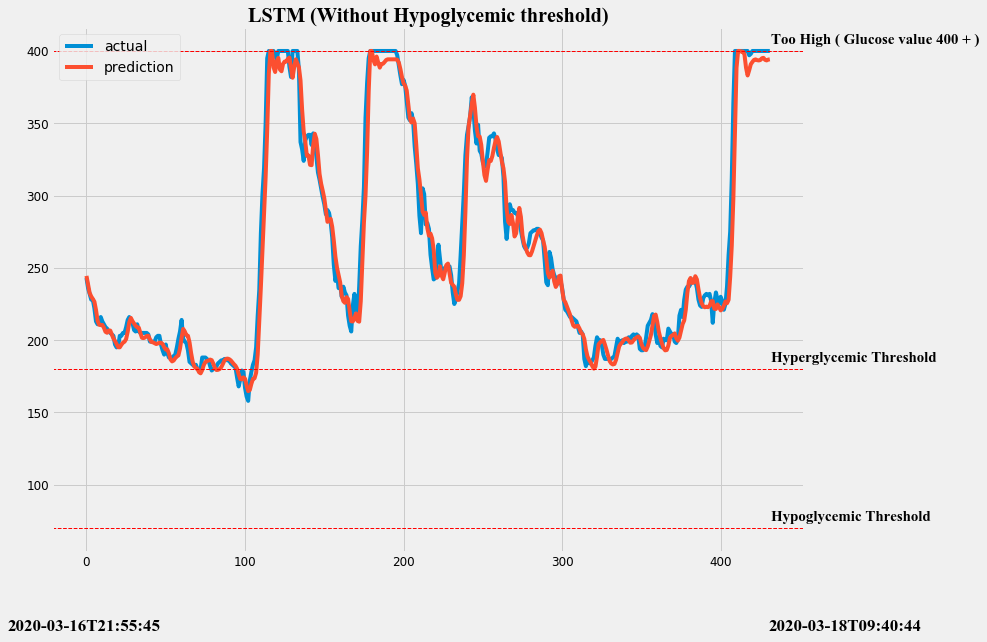

In [102]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [103]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_15 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  11.175007725655632


#### Train

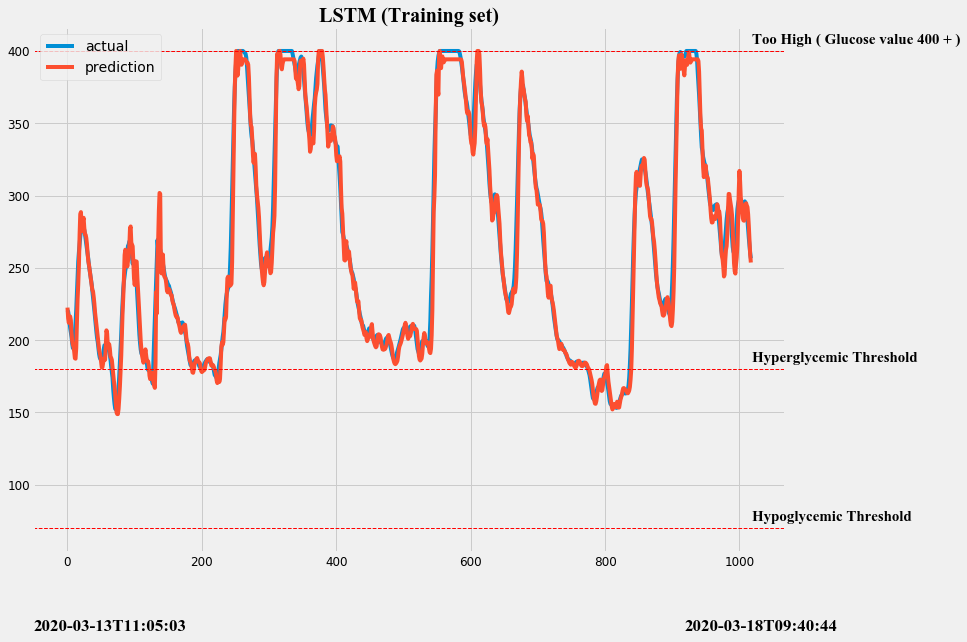

In [104]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 15분

In [105]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [106]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [107]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [108]:
K.clear_session()

In [109]:
predict_result = model.predict(x_val_uni,verbose=0)


In [110]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [111]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_15 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  14.520189014290109


#### Validation

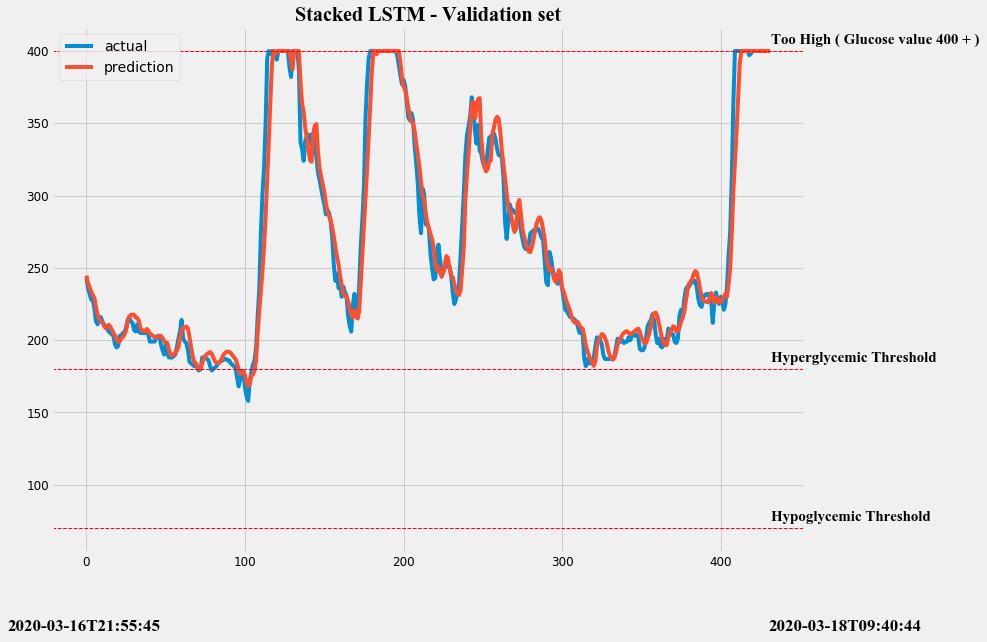

In [112]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Normal Q-Q Plot')

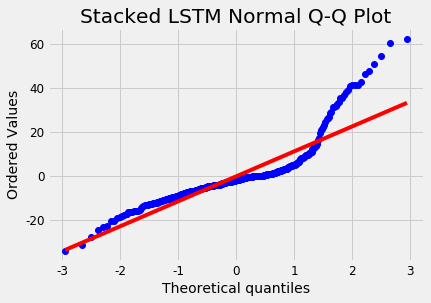

In [113]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Normal Q-Q Plot")

In [114]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  11.390279185987541


#### Train

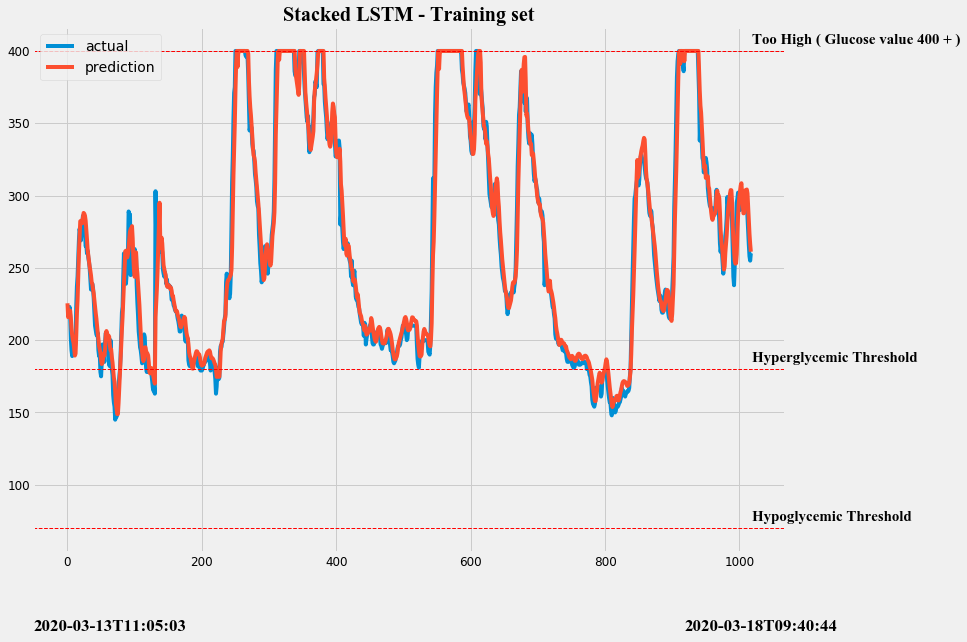

In [115]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 15분

In [116]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [117]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [118]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [119]:
K.clear_session()

In [120]:
predict_result = model.predict(x_val_uni,verbose=0)

In [121]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [122]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_15 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  11.838397395474656


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Normal Q-Q Plot')

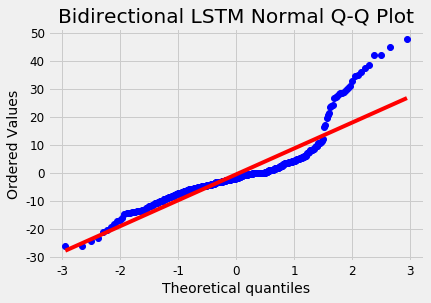

In [123]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Normal Q-Q Plot")

#### Validation

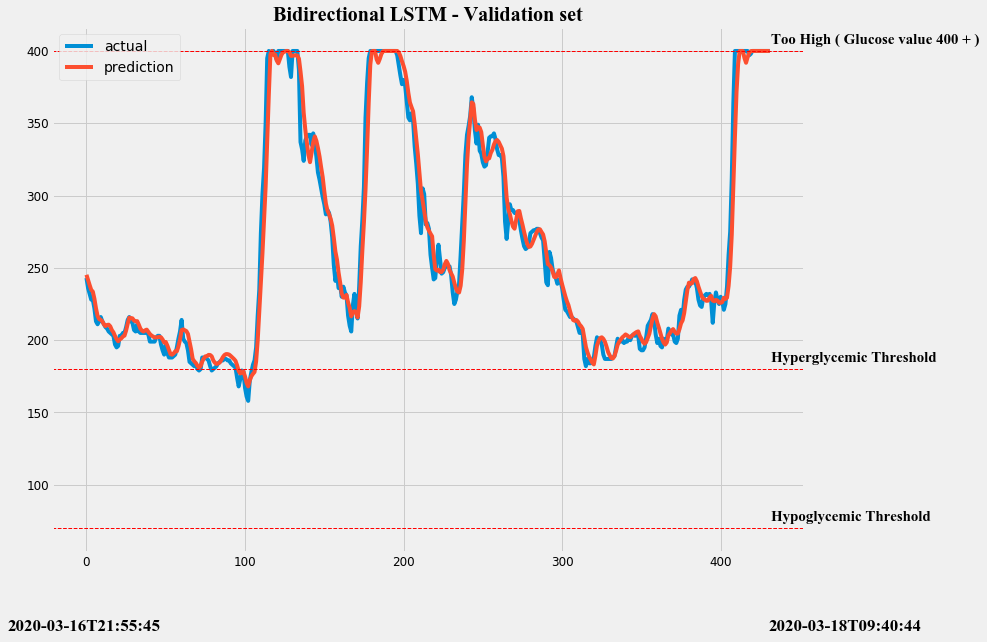

In [124]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [125]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_15 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  10.475102299931889


#### Train

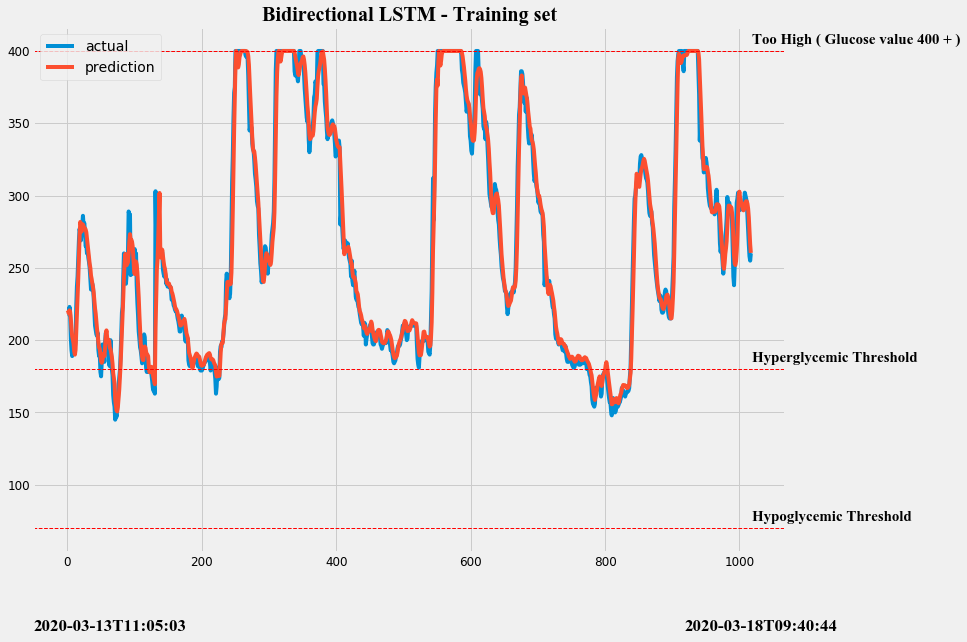

In [126]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 15분

In [127]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [128]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [129]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [131]:
K.clear_session()

In [132]:
predict_result = model.predict(x_val_uni,verbose=0)

In [133]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [134]:
#predict_result

In [135]:
#predict_result

In [136]:

print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_15 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  7.755128962722767


#### 잔차

Text(0.5, 1.0, 'GRU Normal Q-Q Plot')

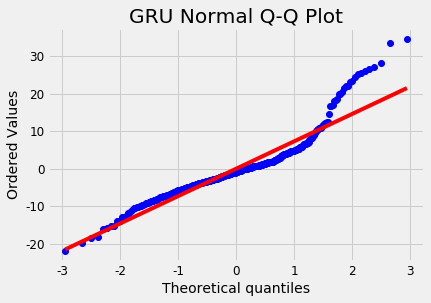

In [137]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Normal Q-Q Plot")

#### Validation

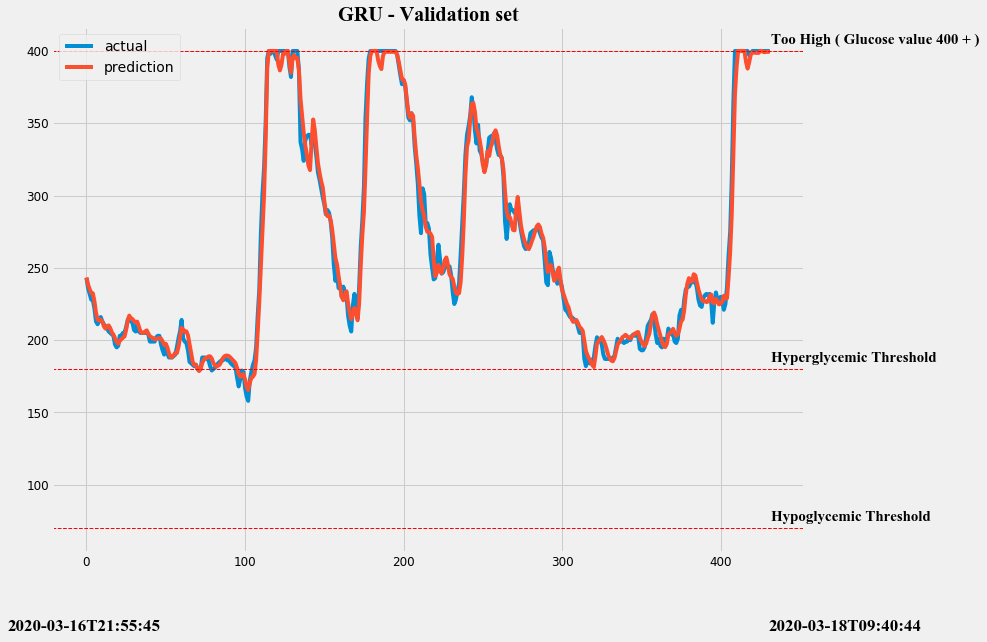

In [138]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [139]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_15 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  7.3305237620273855


#### Train

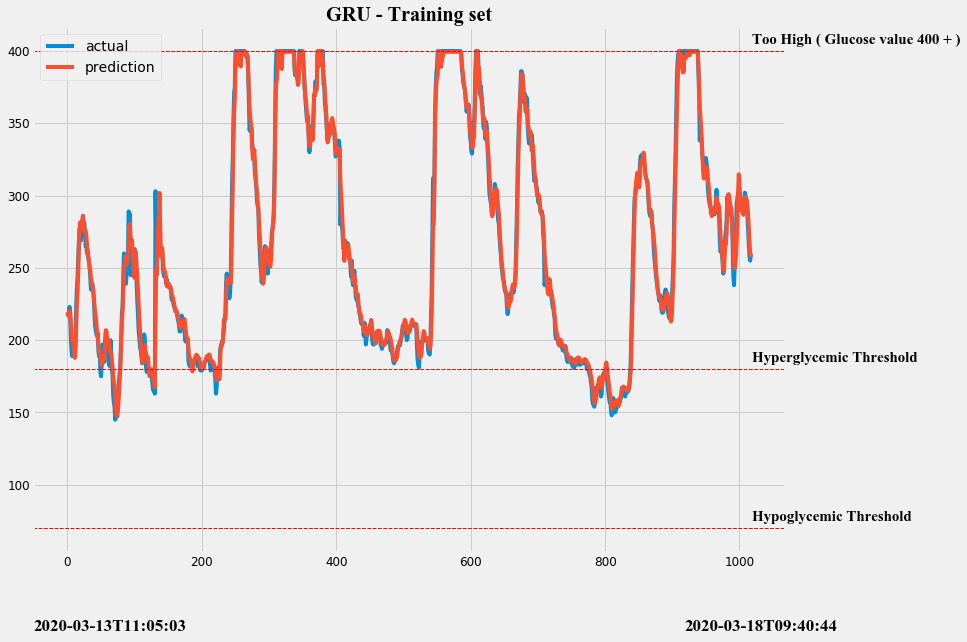

In [140]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

In [141]:
#from pandas import DataFrame
#residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)
#residuals.hist()

In [142]:
#residuals.plot(kind='kde')

In [143]:
#residuals.plot()

In [144]:
#from statsmodels.graphics.gofplots import qqplot
#residuals=np.array(residuals)
#qqplot(residuals)

## 30분

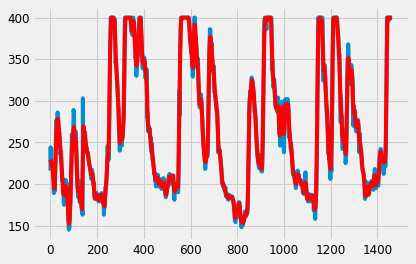

In [145]:
# SG필터 테스트 
import scipy.signal 

yhat = scipy.signal.savgol_filter(raw_seq,7,1)
plt.plot(raw_seq)
plt.plot(yhat,color='red')
plt.show()

In [146]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [147]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=5
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [148]:
x_train_uni.shape


(1018, 6, 1)

In [149]:

x_val_uni.shape

(429, 6, 1)

In [150]:
x_train_uni[0]

array([[229.03571429],
       [228.07142857],
       [227.10714286],
       [226.14285714],
       [227.        ],
       [223.28571429]])

In [151]:
df['Glucose'].head(15)

0     216
1     244
2     227
3     227
4     224
5     223
6     222
7     222
8     218
9     218
10    218
11    223
12    217
13    201
14    193
Name: Glucose, dtype: object

In [152]:
y_train_uni[0]

212.5714285714286

### RNN - 30분

In [153]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [154]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=(n_steps,n_features),return_sequences=False))
model.add(Dense(1))

In [155]:
model.compile(optimizer='adam',loss='mse')

In [156]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [157]:
K.clear_session()

In [158]:
predict_result = model.predict(x_val_uni,verbose=0)

In [159]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [160]:
# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_30 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  28.069802955910493


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

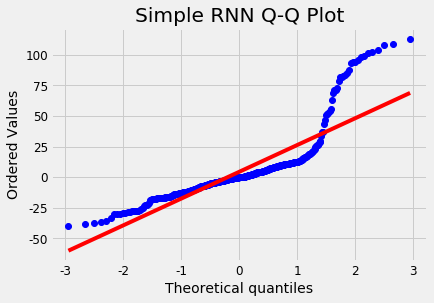

In [161]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

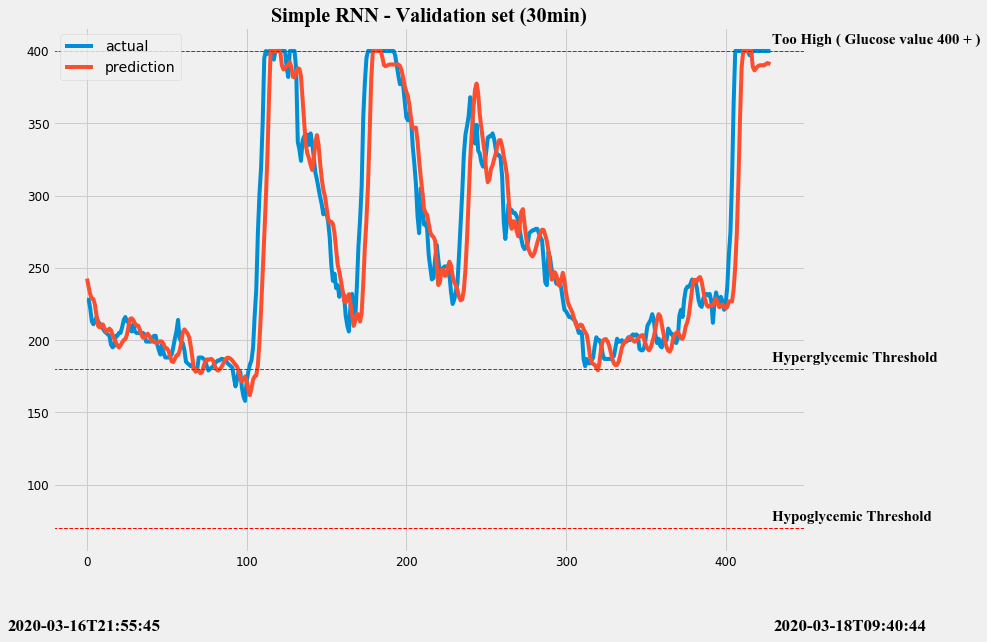

In [162]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 30min Normal Q-Q Plot')

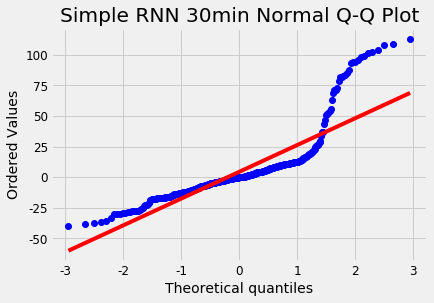

In [163]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 30min Normal Q-Q Plot")

In [164]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_30=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  23.22903208101887


#### Train

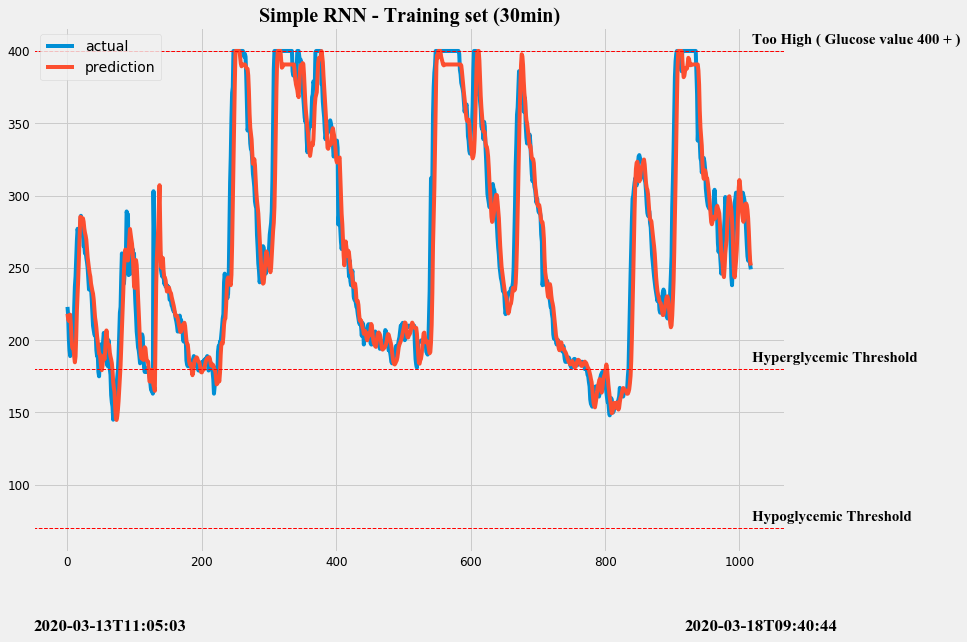

In [165]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 30분

In [166]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [167]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))


In [168]:
model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [169]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_30=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (15min) :  23.301603862723162


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

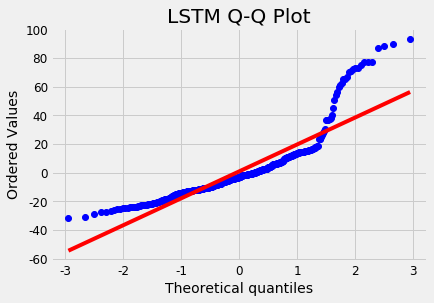

In [170]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

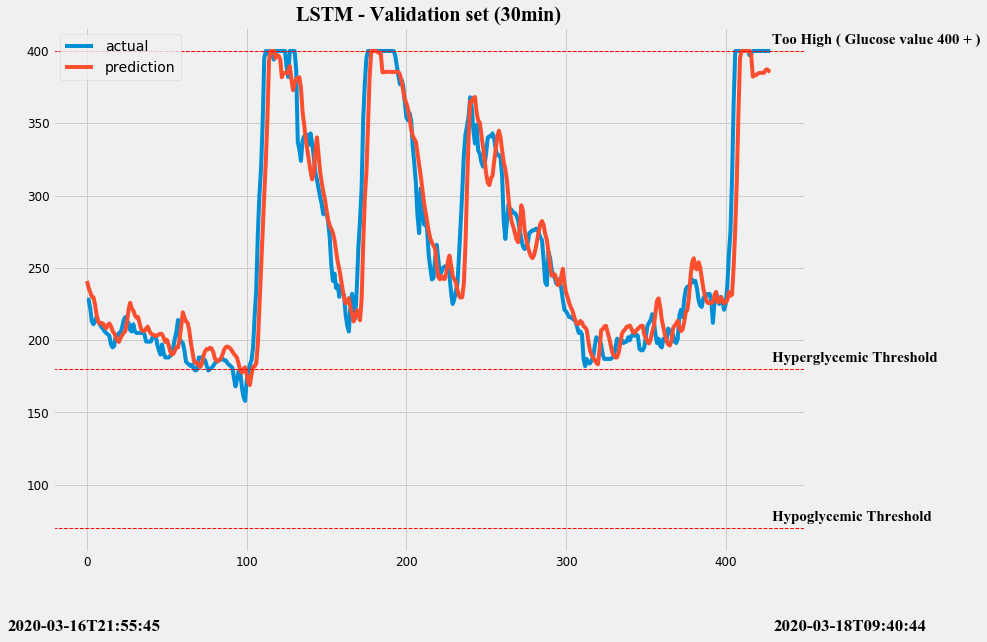

In [171]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [172]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_30 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (15min) Training set :  20.451299382815566


#### Train

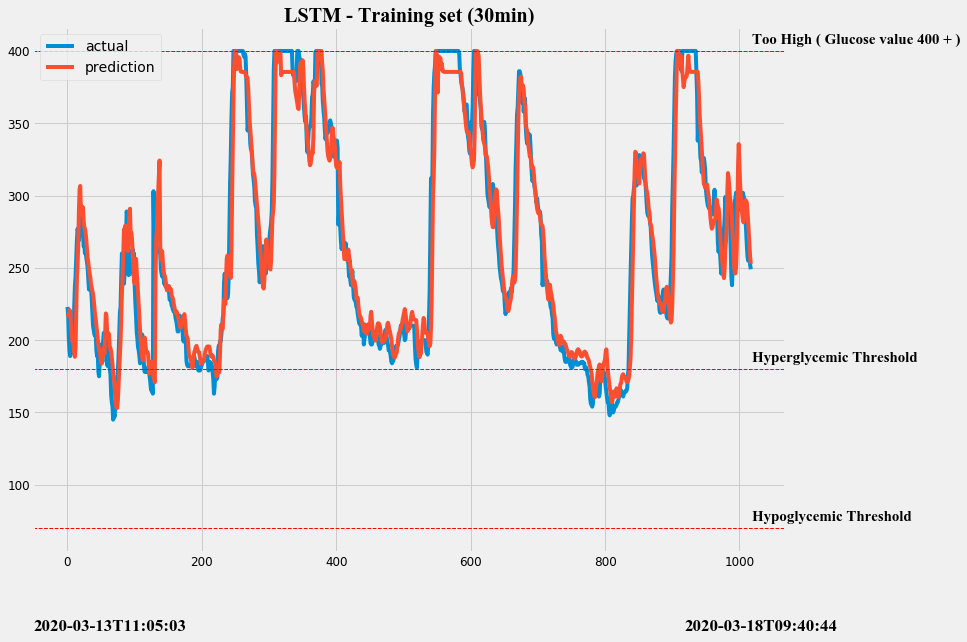

In [173]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (30min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 30분

In [174]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [175]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [176]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [177]:
K.clear_session()

In [178]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_30 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  23.11153260588447


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

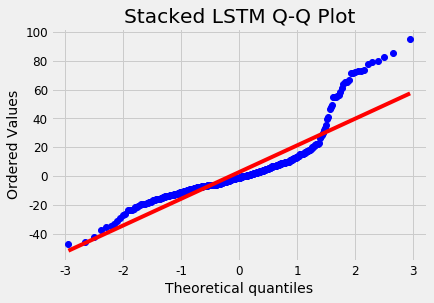

In [179]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

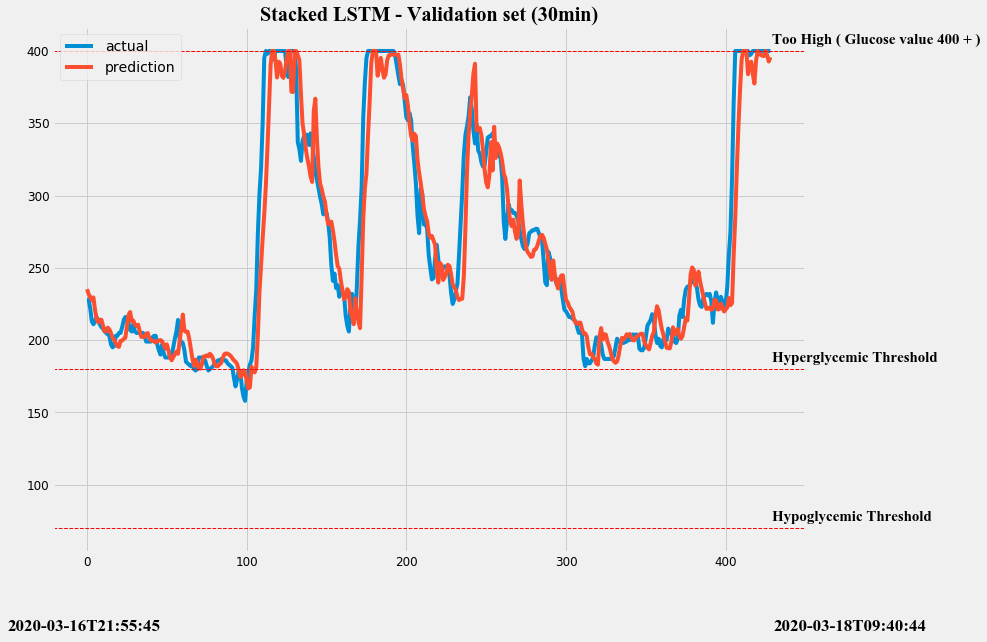

In [180]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [181]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (15min) Training set :  19.475690260829317


#### Train

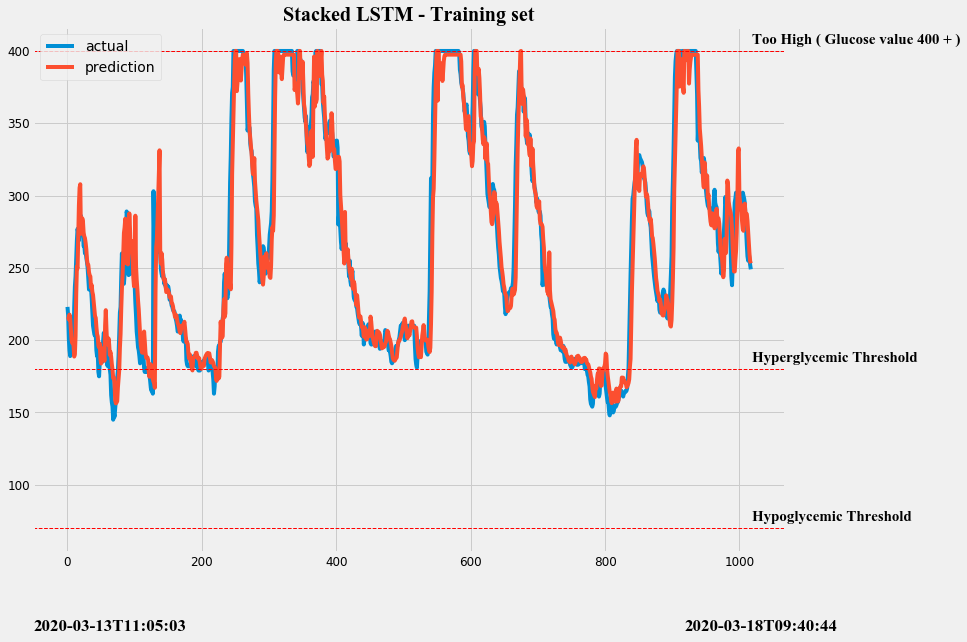

In [182]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 30분

In [183]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [184]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [185]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [186]:
K.clear_session()

In [187]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_30 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  27.935012684255245


#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

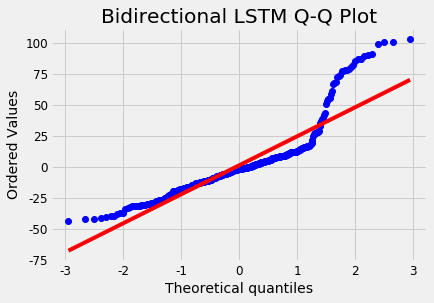

In [188]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

#### Validation

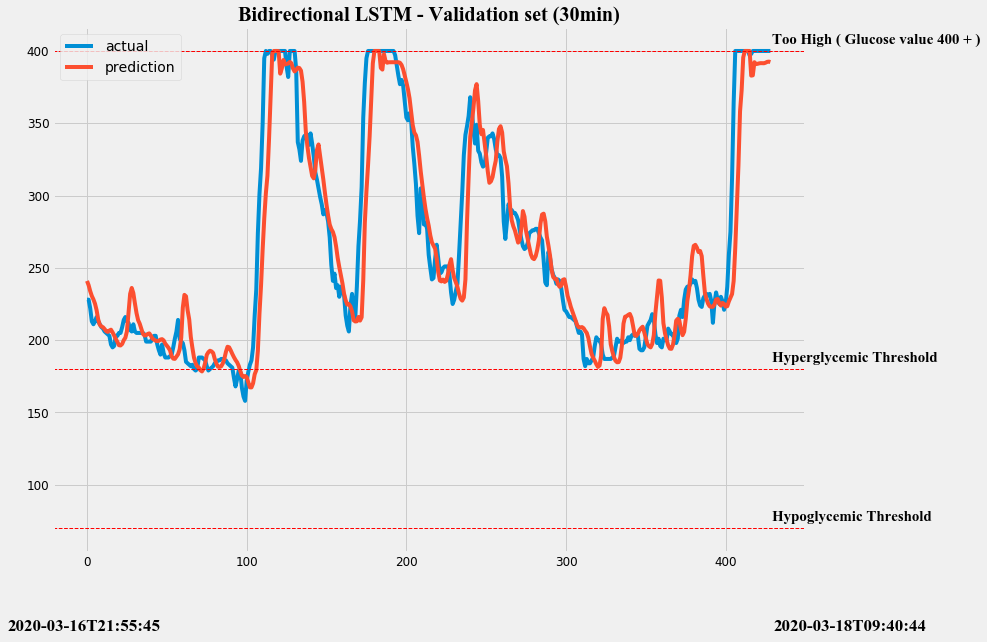

In [189]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (30min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [190]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (30min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_30 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (30min) Training set :  23.00297335699433


#### Train

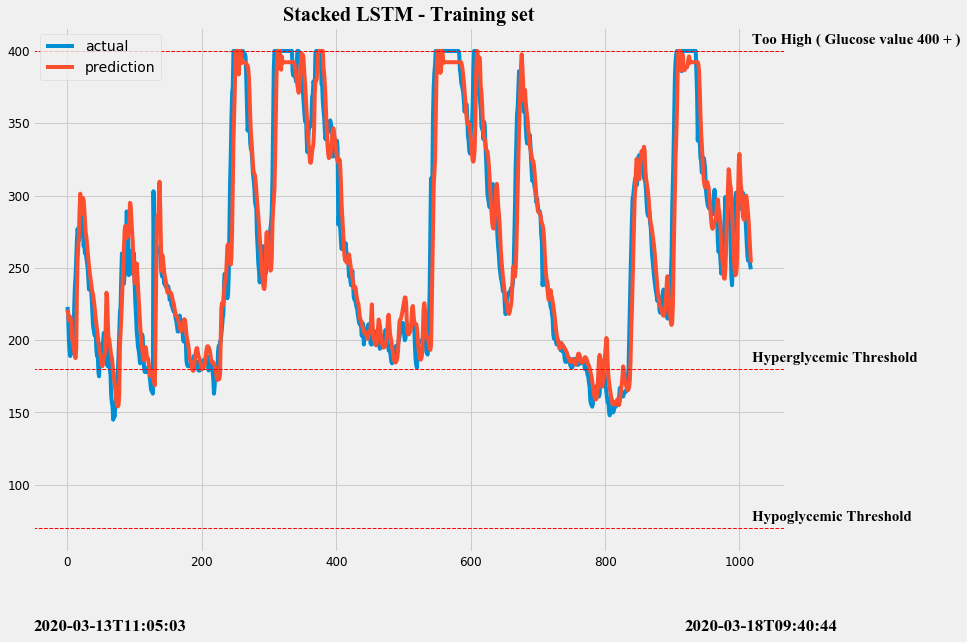

In [191]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 30분

In [192]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [193]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [194]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [195]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni,predict_result))
val_gru_30 = RMSE(y_val_uni,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  19.785947844018157


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

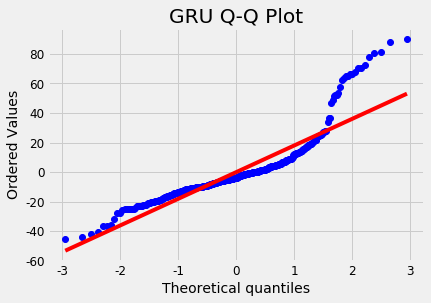

In [196]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

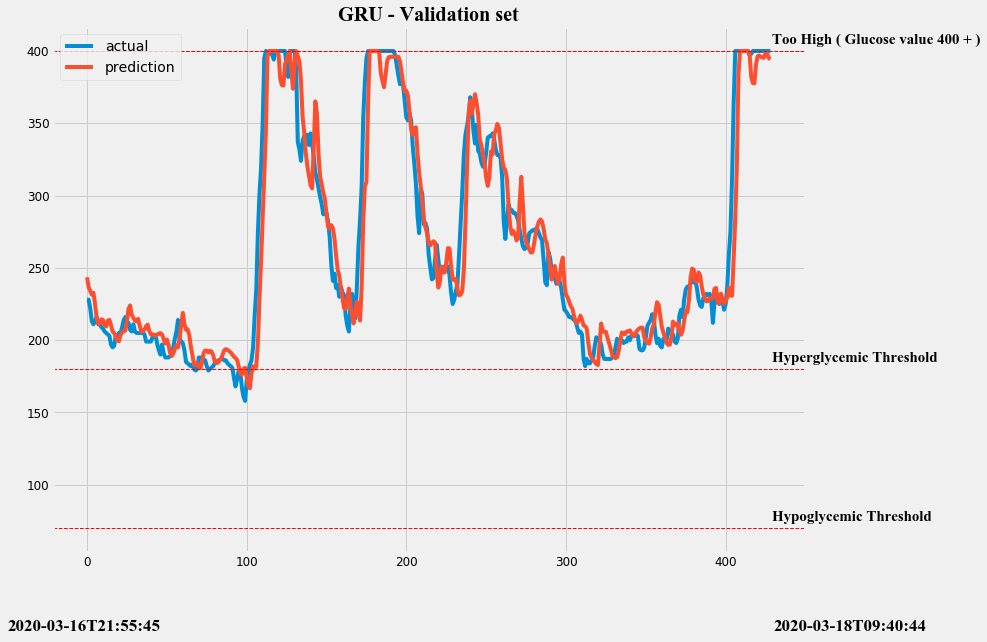

In [197]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [198]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (15min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_30 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (15min) Training set :  19.739431853397843


#### Train

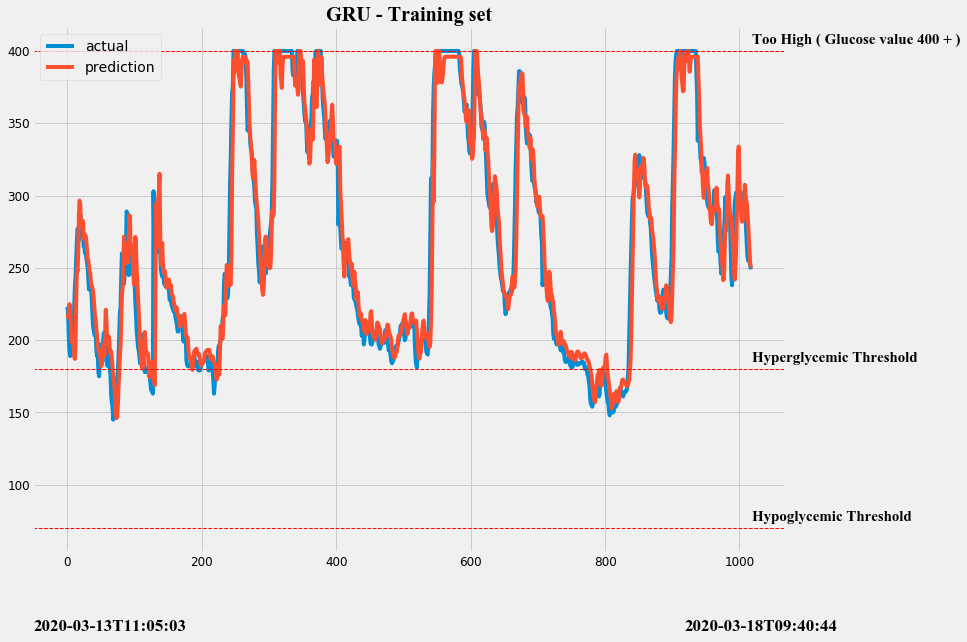

In [199]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 60분

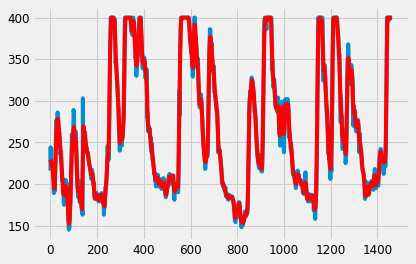

In [200]:
# SG필터 테스트 
import scipy.signal 

yhat = scipy.signal.savgol_filter(raw_seq,7,1)
plt.plot(raw_seq)
plt.plot(yhat,color='red')
plt.show()

In [201]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni,y_train_uni = uni_data(yhat,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(yhat,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [202]:
TRAIN_SPLIT=int(len(raw_seq)*0.7)
uni_past_history=6
uni_future_target=11
x_train_uni_origin,y_train_uni_origin = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni_origin,y_val_uni_origin=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)



In [203]:
x_train_uni[0]

array([[229.03571429],
       [228.07142857],
       [227.10714286],
       [226.14285714],
       [227.        ],
       [223.28571429]])

In [204]:
y_train_uni[0]

194.28571428571433

In [205]:
df['Glucose'].head(20)

0     216
1     244
2     227
3     227
4     224
5     223
6     222
7     222
8     218
9     218
10    218
11    223
12    217
13    201
14    193
15    189
16    197
17    196
18    191
19    195
Name: Glucose, dtype: object

### RNN - 60분

In [206]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [207]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=(n_steps,n_features),return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [208]:
K.clear_session()

In [209]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

# Val set RMSE 
print(' Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_val_uni_origin,predict_result))
val_rnn_60 = RMSE(y_val_uni_origin,predict_result)


 Vanila RNN (Simple RNN) - RMSE (15min) :  51.1258595479807


#### 잔차

Text(0.5, 1.0, 'Simple RNN Q-Q Plot')

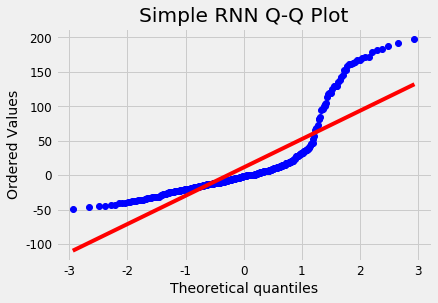

In [210]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN Q-Q Plot")

#### Validation

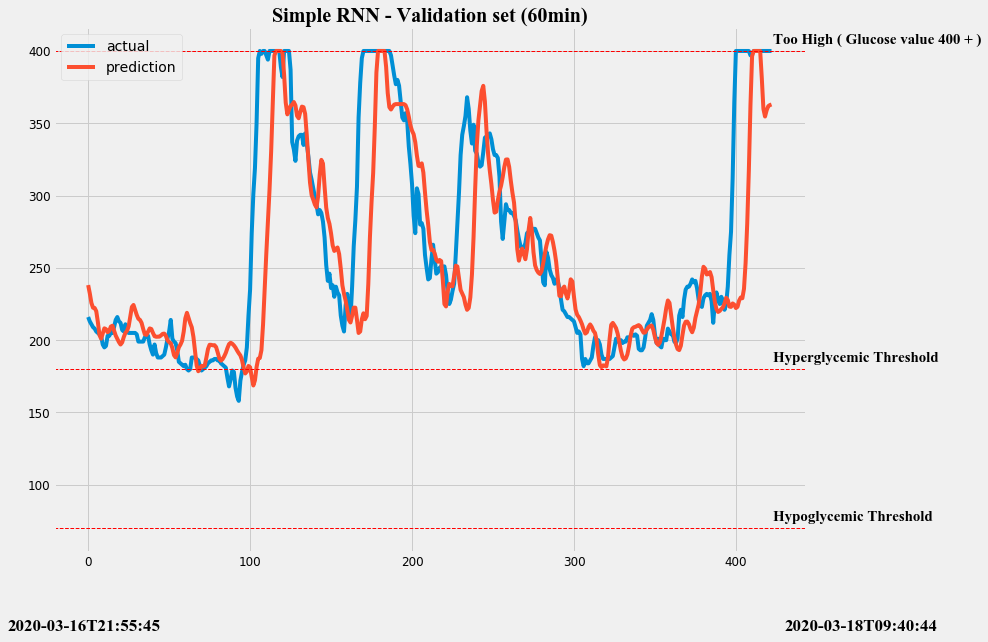

In [211]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

Text(0.5, 1.0, 'Simple RNN 60min Normal Q-Q Plot')

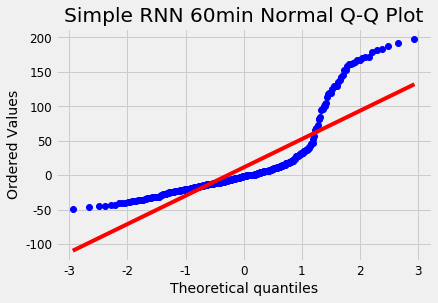

In [212]:
from pandas import DataFrame
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import probplot

#residuals=DataFrame(residuals)

residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)

#residuals

probplot(residuals,dist="norm",plot=plt)
plt.title("Simple RNN 60min Normal Q-Q Plot")

In [213]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni_origin,predict_result))
train_rnn_60=RMSE(y_train_uni_origin,predict_result)

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  43.05095985825092


#### Train

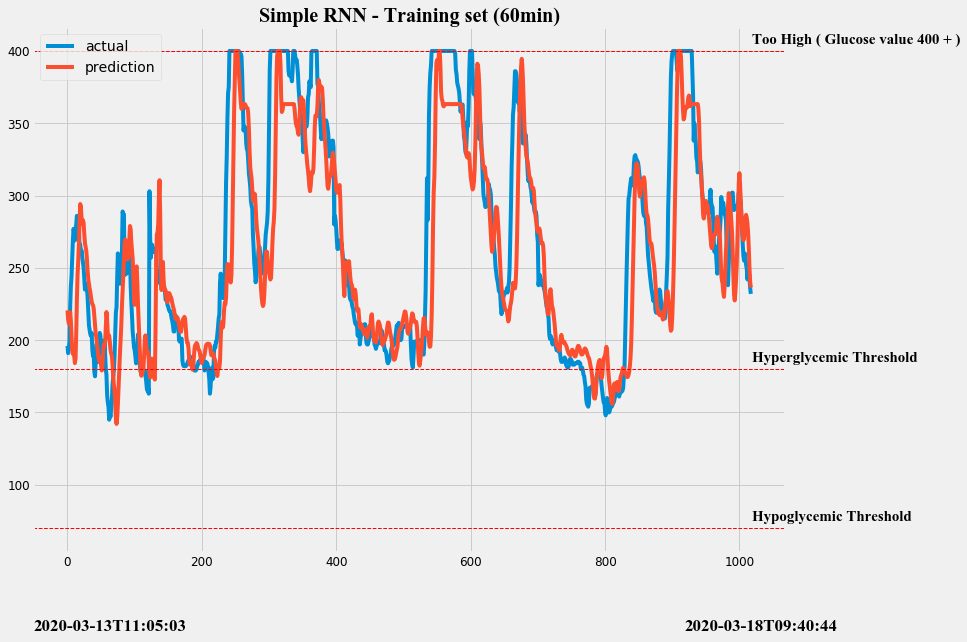

In [214]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Simple RNN - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### LSTM - 60분

In [215]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [216]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))


model.compile(optimizer='adam',loss='mse')

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [217]:
predict_result = model.predict(x_val_uni,verbose=0)

# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni_origin,predict_result))
val_lstm_60=RMSE(y_val_uni_origin,predict_result)

 LSTM - RMSE (60min) :  51.988975951962594


#### 잔차

Text(0.5, 1.0, 'LSTM Q-Q Plot')

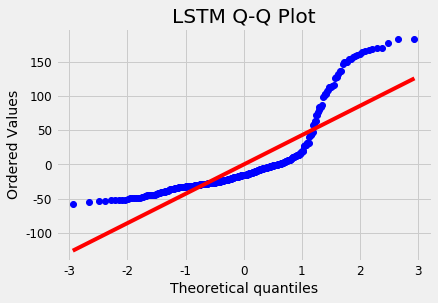

In [218]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("LSTM Q-Q Plot")

#### Validation

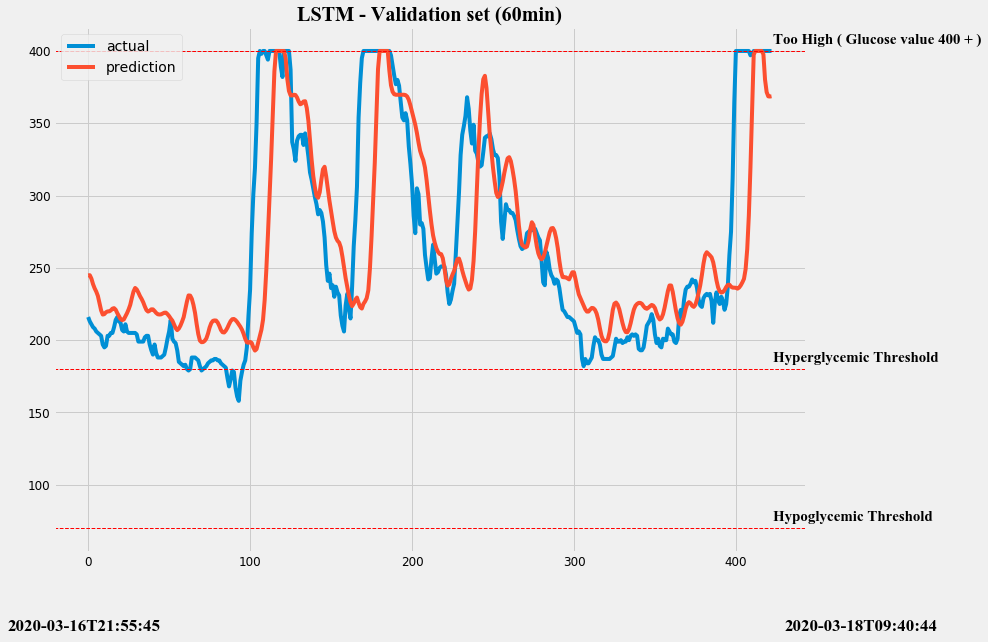

In [219]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [220]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_lstm_60 =RMSE(y_train_uni_origin,predict_result)

 LSTM - RMSE (60min) Training set :  44.45338200170214


#### Train

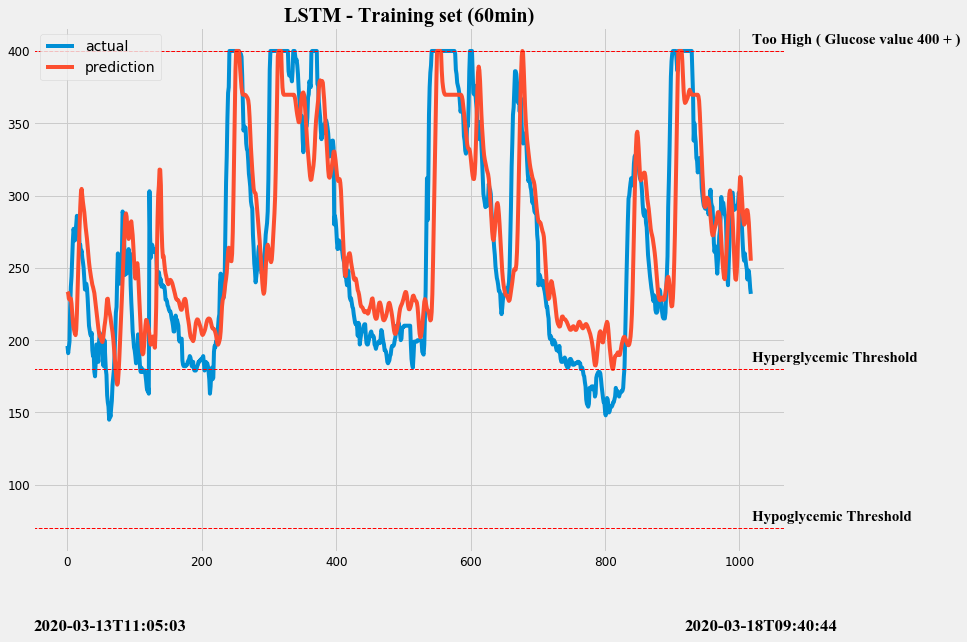

In [221]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend()
plt.show()

### Stacked LSTM - 60분

In [222]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [223]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [224]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [225]:
predict_result = model.predict(x_val_uni,verbose=0)


for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni_origin,predict_result))
val_stacklstm_60 =RMSE(y_val_uni_origin,predict_result)

 Stacked LSTM - RMSE(15min) :  49.03510084535601


#### 잔차

Text(0.5, 1.0, 'Stacked LSTM Q-Q Plot')

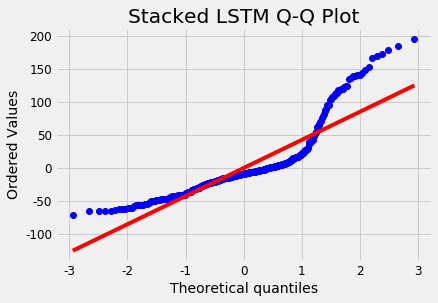

In [226]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Stacked LSTM Q-Q Plot")

#### Validation

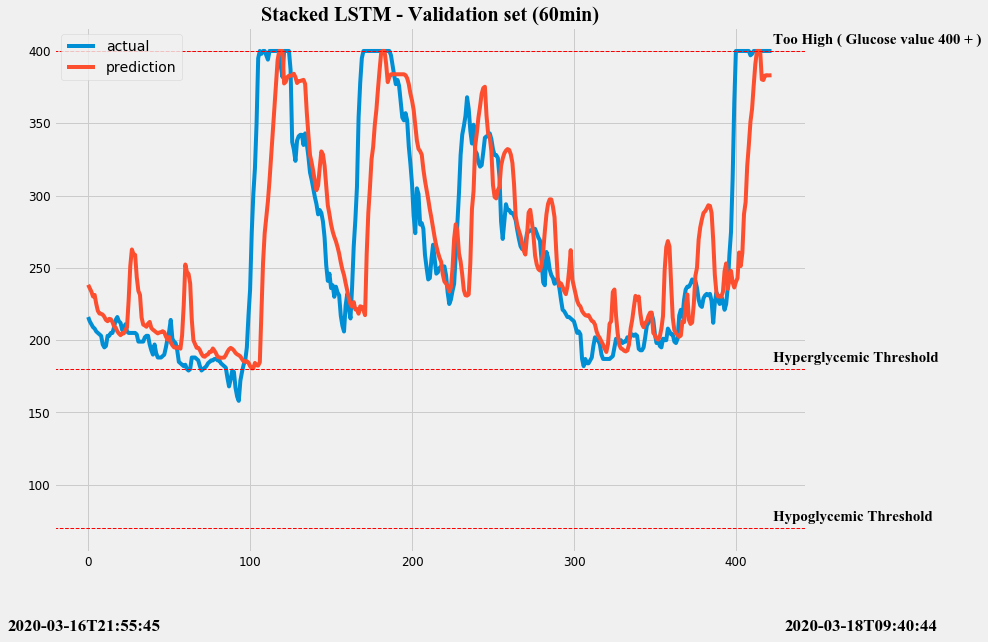

In [227]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [228]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_stacklstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / STACKED LSTM - RMSE (60min) Training set :  39.79163125582559


#### Train

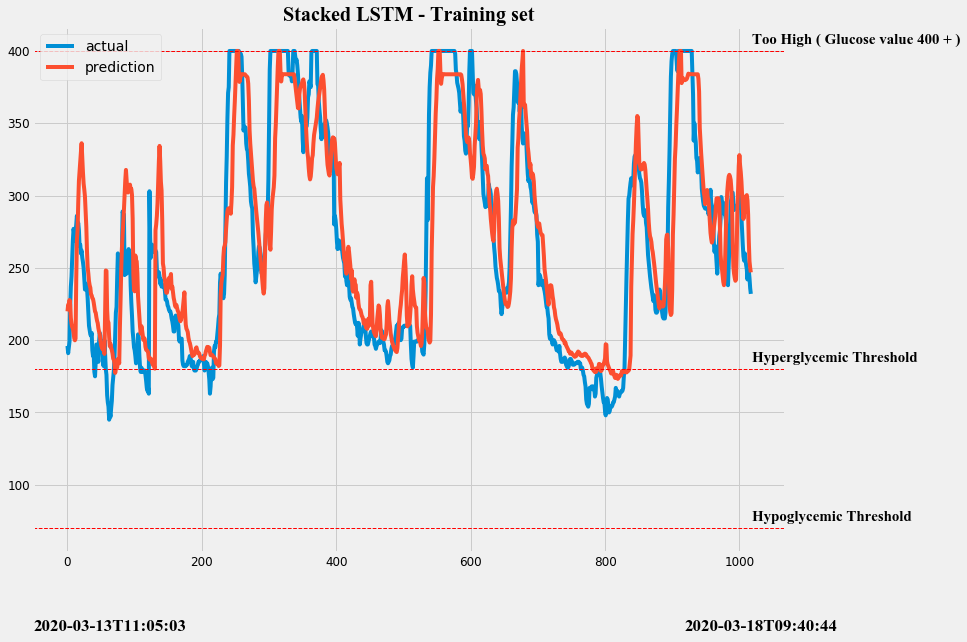

In [229]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### Bidirectional LSTM - 60분

In [230]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [231]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [232]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

In [233]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni_origin,predict_result))
val_bilstm_60 = RMSE(y_val_uni_origin,predict_result)

Bidirectional LSTM - RMSE :  51.03987279145369


#### Validation

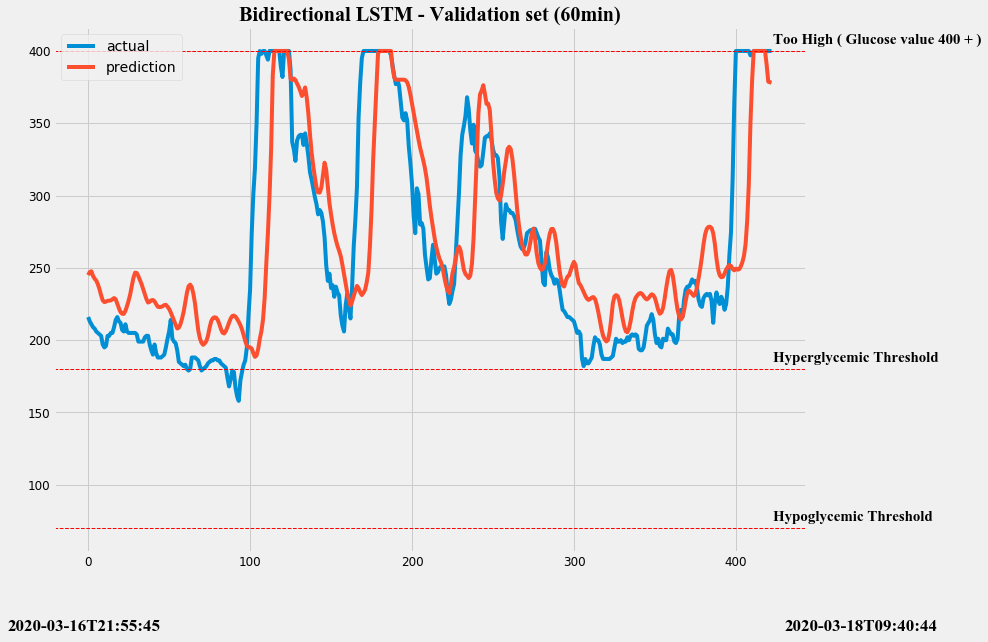

In [234]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Bidirectional LSTM - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

#### 잔차

Text(0.5, 1.0, 'Bidirectional LSTM Q-Q Plot')

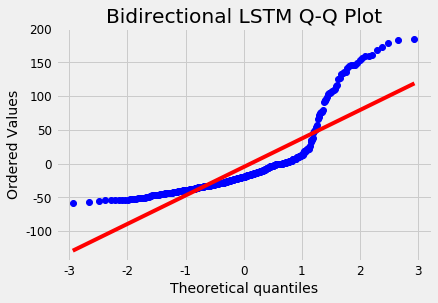

In [235]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("Bidirectional LSTM Q-Q Plot")

In [236]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_bilstm_60 = RMSE(y_train_uni_origin,predict_result)

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  43.82497939881134


#### Train

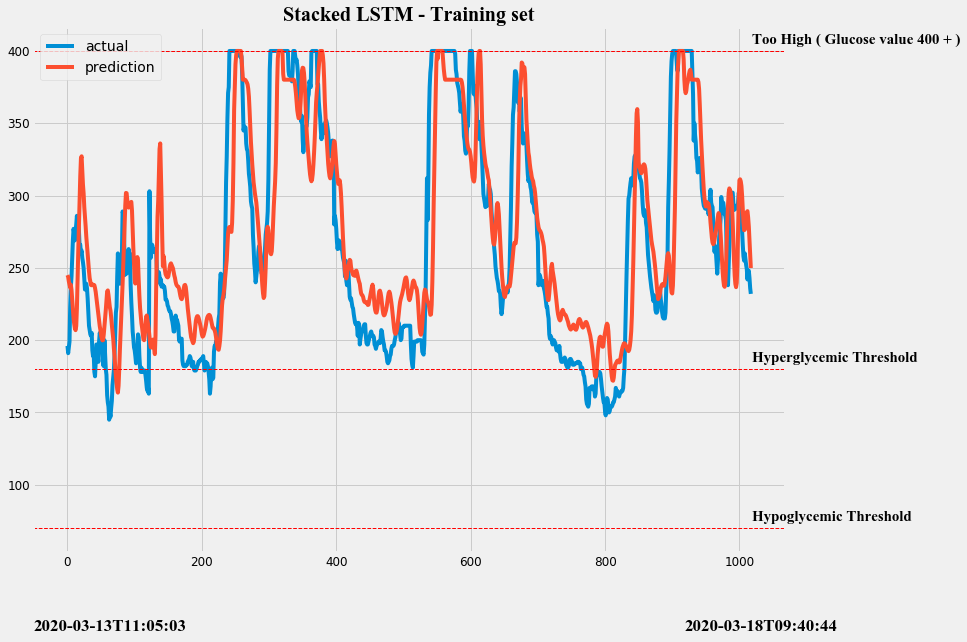

In [237]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Stacked LSTM - Training set',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

### GRU - 60분

In [238]:
# 재현 가능한 결과를 만들기 위해 
# 매번 반복해야 하는 작업 
seed_num = 42
random.seed(seed_num)
np.random.seed(seed_num)
tf.random.set_seed(seed_num)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                             inter_op_parallelism_threads=1)
sess=tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),config=session_conf)
K.set_session(sess)

In [239]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [240]:
model.summary()

model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

K.clear_session()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [241]:
predict_result = model.predict(x_val_uni,verbose=0)

for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

#predict_result

#predict_result


print('GRU - RMSE 15min : ',RMSE(y_val_uni_origin,predict_result))
val_gru_60 = RMSE(y_val_uni_origin,predict_result)
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE 15min :  50.10272459969577


#### 잔차

Text(0.5, 1.0, 'GRU Q-Q Plot')

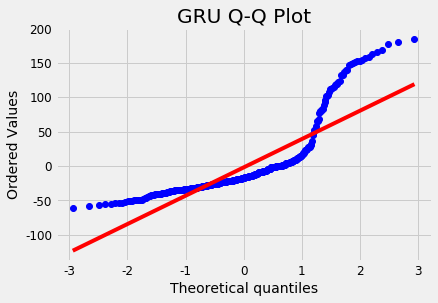

In [242]:
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals = y_val_uni - predict_result.reshape(-1)
probplot(residuals,dist="norm",plot=plt)
plt.title("GRU Q-Q Plot")

#### Validation

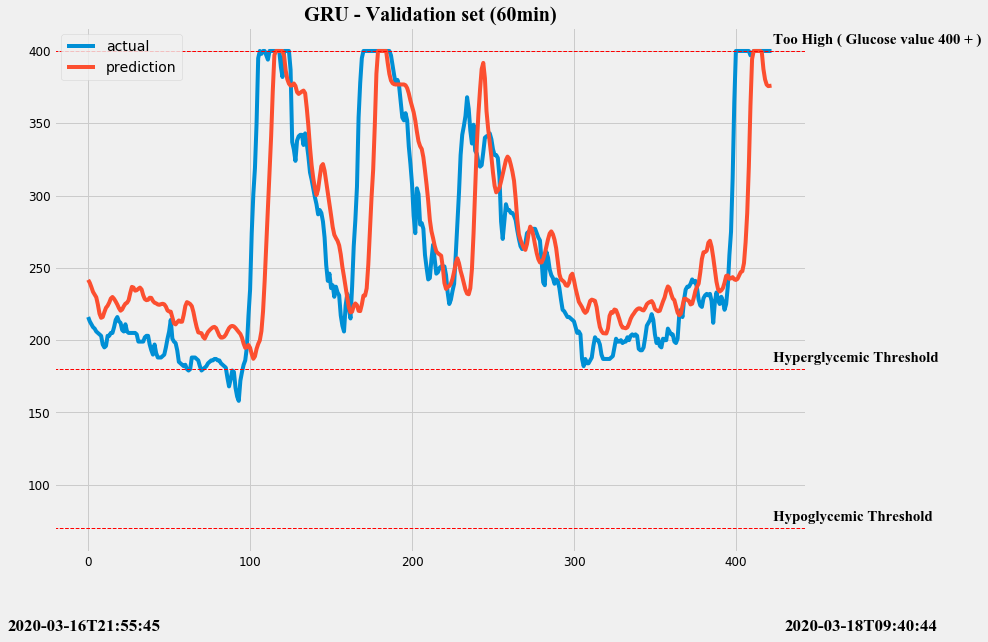

In [243]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(-50,-1,df['Timestamp'][TRAIN_SPLIT],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp'])-TRAIN_SPLIT-10,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Validation set (60min)',family='Times New Roman')
plt.legend(loc='best')

plt.show()

In [244]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni_origin,predict_result))
train_gru_60 =RMSE(y_train_uni_origin,predict_result)

 Training set / GRU - RMSE (60min) Training set :  42.22269537264551


#### Train

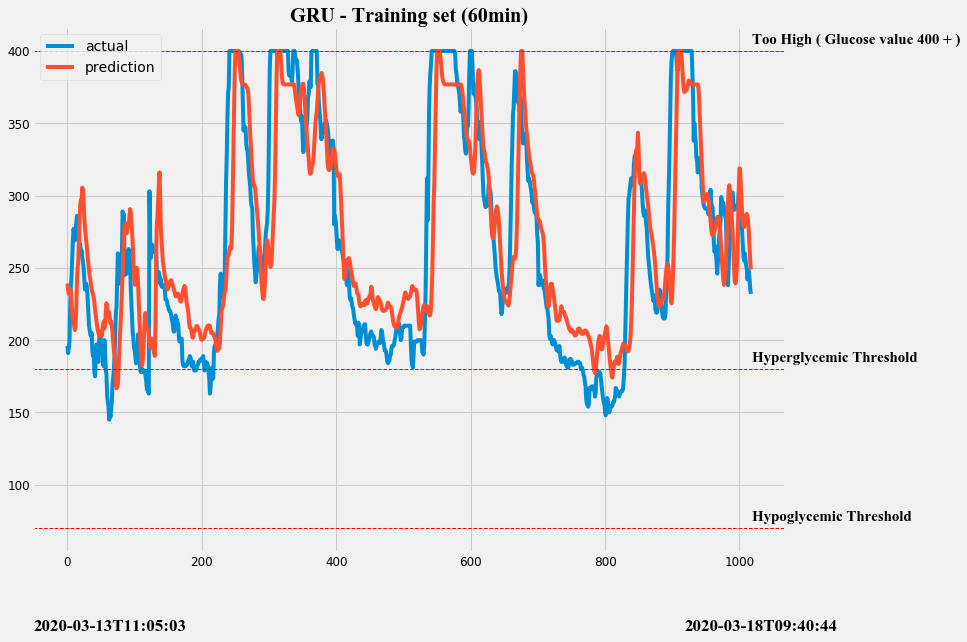

In [245]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni_origin,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('GRU - Training set (60min)',family='Times New Roman')
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
#plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.text(-50,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(predict_result)-100,-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)

plt.legend(loc='best')
plt.show()

## 결과

In [246]:
train_15_result = [train_rnn_15,train_lstm_15,train_stacklstm_15,train_bilstm_15,train_gru_15]
val_15_result =[val_rnn_15,val_lstm_15,val_stacklstm_15,val_bilstm_15,val_gru_15]
train_30_result = [train_rnn_30,train_lstm_30,train_stacklstm_30,train_bilstm_30,train_gru_30]
val_30_result =[val_rnn_30,val_lstm_30,val_stacklstm_30,val_bilstm_30,val_gru_30]
train_60_result = [train_rnn_60,train_lstm_60,train_stacklstm_60,train_bilstm_60,train_gru_60]
val_60_result =[val_rnn_60,val_lstm_60,val_stacklstm_60,val_bilstm_60,val_gru_60]


In [247]:
val_rnn_result = [val_rnn_15,val_rnn_30,val_rnn_60]
val_lstm_result = [val_lstm_15,val_lstm_30,val_lstm_60]
val_stacklstm_result = [val_stacklstm_15,val_stacklstm_30,val_stacklstm_60]
val_bilstm_result = [val_bilstm_15,val_bilstm_30,val_bilstm_60]
val_gru_result = [val_gru_15,val_gru_30,val_gru_60]

In [248]:
train_rnn_result = [train_rnn_15,train_rnn_30,train_rnn_60]
train_lstm_result = [train_lstm_15,train_lstm_30,train_lstm_60]
train_stacklstm_result = [train_stacklstm_15,train_stacklstm_30,train_stacklstm_60]
train_bilstm_result = [train_bilstm_15,train_bilstm_30,train_bilstm_60]
train_gru_result = [train_gru_15,train_gru_30,train_gru_60]

In [249]:
train_result_list =[train_rnn_result,train_lstm_result,train_stacklstm_result,train_bilstm_result,train_gru_result]

In [250]:
val_result_list =[val_rnn_result,val_lstm_result,val_stacklstm_result,val_bilstm_result,val_gru_result]

In [251]:
val_result_list

[[10.197750020810199, 28.069802955910493, 51.1258595479807],
 [12.218394394129966, 23.301603862723162, 51.988975951962594],
 [14.520189014290109, 23.11153260588447, 49.03510084535601],
 [11.838397395474656, 27.935012684255245, 51.03987279145369],
 [7.755128962722767, 19.785947844018157, 50.10272459969577]]

In [252]:
val_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=val_result_list)
val_df

15 MIN     30 MIN     60 MIN
RNN                 10.197750  28.069803  51.125860
LSTM                12.218394  23.301604  51.988976
Stacked LSTM        14.520189  23.111533  49.035101
Bidirectional LSTM  11.838397  27.935013  51.039873
GRU                  7.755129  19.785948  50.102725

In [253]:
train_df = pd.DataFrame(index=['RNN','LSTM','Stacked LSTM','Bidirectional LSTM','GRU'], 
                      columns =['15 MIN','30 MIN','60 MIN'],data=train_result_list)
train_df

15 MIN     30 MIN     60 MIN
RNN                  8.998847  23.229032  43.050960
LSTM                11.175008  20.451299  44.453382
Stacked LSTM        11.390279  19.475690  39.791631
Bidirectional LSTM  10.475102  23.002973  43.824979
GRU                  7.330524  19.739432  42.222695

## CNN LSTM